In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model_bn2, lr_decay, modelbestcheck, modelbestcheck_weights)

from nn_training import train_model

from nn_pruning import prune_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_4_0
[INFO    ] Using numpy 1.15.1
[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 2.2.3


In [2]:
# Training parameters

do_training = True

run2_input = False

omtf_input = False

displ_input = True

model_name = 'model'

epochs = 300

batch_size = 4096

tile = 6

# ______________________________________________________________________________
if omtf_input:
  from nn_encode_omtf import nlayers, nvariables
  from nn_data_omtf import (muon_data_split, pileup_data_split, mix_training_inputs)
  
  model_name = 'model_omtf'
  
  epochs = 450
  
  tile = 11

# ______________________________________________________________________________
if displ_input:
  model_name = 'model_displ'
  
  epochs = 300

### Import data

In [3]:
infile_muon_no_displ = '../test7/histos_tba_no_displ.24.npz'

infile_muon_displ = '../test7/histos_tba_displ.24.npz'

nentries = 800000

In [4]:
from sklearn.model_selection import train_test_split

from nn_encode import Encoder

def muon_data(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, correct_for_eta=False):
  try:
    logger.info('Loading muon data from {0} ...'.format(filename))
    loaded = np.load(filename)
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']
    the_variables = the_variables[:nentries]
    the_parameters = the_parameters[:nentries]
    logger.info('Loaded the variables with shape {0}'.format(the_variables.shape))
    logger.info('Loaded the parameters with shape {0}'.format(the_parameters.shape))
  except:
    logger.error('Failed to load data from file: {0}'.format(filename))

  assert(the_variables.shape[0] == the_parameters.shape[0])

  encoder = Encoder(the_variables, the_parameters, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale)
  if correct_for_eta:
    x, y, dxy, dz, w, x_mask, x_road = encoder.get_x(), encoder.get_y_corrected_for_eta(), encoder.get_dxy(), encoder.get_dz(), encoder.get_w(), encoder.get_x_mask(), encoder.get_x_road()
  else:
    x, y, dxy, dz, w, x_mask, x_road = encoder.get_x(), encoder.get_y(), encoder.get_dxy(), encoder.get_dz(), encoder.get_w(), encoder.get_x_mask(), encoder.get_x_road()
  
  logger.info('Loaded the encoded variables with shape {0}'.format(x.shape))
  logger.info('Loaded the encoded parameters with shape {0}'.format(y.shape))
  assert(np.isfinite(x).all())
  return x, y, dxy, dz, w, x_mask, x_road

def muon_data_split(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, test_size=0.5, correct_for_eta=False):
  x, y, dxy, dz, w, x_mask, x_road = muon_data(filename, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, correct_for_eta=correct_for_eta)

  # Split dataset in training and testing
  x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = train_test_split(x, y, dxy, dz, w, x_mask, x_road, test_size=test_size)
  logger.info('Loaded # of training and testing events: {0}'.format((x_train.shape[0], x_test.shape[0])))

  # Check for cases where the number of events in the last batch could be too few
  validation_split = 0.1
  train_num_samples = int(x_train.shape[0] * (1.0-validation_split))
  val_num_samples = x_train.shape[0] - train_num_samples
  batch_size = 128
  if (train_num_samples%batch_size) < 100:
    logger.warning('The last batch for training could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
    logger.warning('Try this formula: int(int({0}*{1})*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
  train_num_samples = int(x_train.shape[0] * 2 * (1.0-validation_split))
  val_num_samples = x_train.shape[0] - train_num_samples
  batch_size = 128
  if (train_num_samples%batch_size) < 100:
    logger.warning('The last batch for training after mixing could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
    logger.warning('Try this formula: int(int({0}*{1})*2*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
  return x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test

In [5]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
      muon_data_split(infile_muon_no_displ, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=0.31)

[INFO    ] Loading muon data from ../test7/histos_tba_no_displ.24.npz ...
[INFO    ] Loaded the variables with shape (800000, 179)
[INFO    ] Loaded the parameters with shape (800000, 5)
[INFO    ] Loaded the encoded variables with shape (800000, 36)
[INFO    ] Loaded the encoded parameters with shape (800000,)
[INFO    ] Loaded # of training and testing events: (552000, 248000)
[WARNING ] The last batch for training could be too few! (496800%128)=32. Please change test_size.
[WARNING ] Try this formula: int(int(800000*0.69)*0.9) % 128
[WARNING ] The last batch for training after mixing could be too few! (993600%128)=64. Please change test_size.
[WARNING ] Try this formula: int(int(800000*0.69)*2*0.9) % 128


In [6]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ, dz_train_displ, dz_test_displ, w_train_displ, w_test_displ, x_mask_train_displ, x_mask_test_displ, x_road_train_displ, x_road_test_displ = \
      muon_data_split(infile_muon_displ, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=0.31)

[INFO    ] Loading muon data from ../test7/histos_tba_displ.24.npz ...
[INFO    ] Loaded the variables with shape (800000, 179)
[INFO    ] Loaded the parameters with shape (800000, 5)
[INFO    ] Loaded the encoded variables with shape (800000, 36)
[INFO    ] Loaded the encoded parameters with shape (800000,)
[INFO    ] Loaded # of training and testing events: (552000, 248000)
[WARNING ] The last batch for training could be too few! (496800%128)=32. Please change test_size.
[WARNING ] Try this formula: int(int(800000*0.69)*0.9) % 128
[WARNING ] The last batch for training after mixing could be too few! (993600%128)=64. Please change test_size.
[WARNING ] Try this formula: int(int(800000*0.69)*2*0.9) % 128


### Training (Part I)

Try different cases:
- (a) Train with prompt muons, apply to prompt muons
- (b) Train with displaced muons, apply to displaced muons
- (c) Train with displaced muons, apply to prompt muons
- (d) Train with prompt muons, apply to displaced muons

In [7]:
from nn_models import Sequential, Dense, BatchNormalization, Activation, regularizers, optimizers, huber_loss

def create_model_sequential_bn2(nvariables, lr=0.001, clipnorm=10., nodes1=64, nodes2=32, nodes3=16, nodes4=0, nodes5=0, outnodes=1,
                                l1_reg=0.0, l2_reg=0.0, use_bn=True, use_dropout=False):
  # Adding 1 BN layer right after the input layer
  regularizer = regularizers.L1L2(l1=l1_reg, l2=l2_reg)

  model = Sequential()
  if use_bn: model.add(BatchNormalization(input_shape=(nvariables,), epsilon=1e-4, momentum=0.9))

  model.add(Dense(nodes1, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
  if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
  model.add(Activation('tanh'))
  if nodes2:
    model.add(Dense(nodes2, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
    if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
    model.add(Activation('tanh'))
    if nodes3:
      model.add(Dense(nodes3, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
      if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
      model.add(Activation('tanh'))
      if nodes4:
        model.add(Dense(nodes4, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
        if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
        model.add(Activation('tanh'))
        if nodes5:
          model.add(Dense(nodes5, kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, use_bias=False))
          if use_bn: model.add(BatchNormalization(epsilon=1e-4, momentum=0.9))
          model.add(Activation('tanh'))

  # Output node
  model.add(Dense(outnodes, activation='linear', kernel_initializer='glorot_uniform'))

  # Set loss and optimizers
  adam = optimizers.Adam(lr=lr, clipnorm=clipnorm)
  model.compile(optimizer=adam, loss=huber_loss, metrics=['acc'])
  #model.compile(optimizer=adam, loss=unmasked_huber_loss, metrics=['acc'])
  model.summary()
  return model

In [8]:
model = create_model_sequential_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=50, nodes2=40, nodes3=30, nodes4=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 36)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1800      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2000      
_________________________________________________________________
batch_normalization_3 (Batch (None, 40)                160       
_________________________________________________________________
activation_2 (Activation)    (None, 40)                0         
__________

In [9]:
logger.info('Begin training ...')
history = model.fit(x_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, verbose=0)
logger.info('Done training.')
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
    len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

[INFO    ] Begin training ...
[INFO    ] Done training.
[INFO    ] Epoch 300/300 - loss: 3.18139201709 - val_loss: 3.16785603827


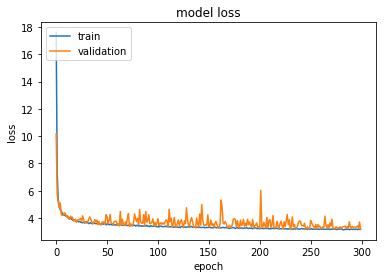

In [10]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [11]:
model_displ = create_model_sequential_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=50, nodes2=40, nodes3=30, nodes4=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 36)                144       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1800      
_________________________________________________________________
batch_normalization_7 (Batch (None, 50)                200       
_________________________________________________________________
activation_5 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 40)                2000      
_________________________________________________________________
batch_normalization_8 (Batch (None, 40)                160       
_________________________________________________________________
activation_6 (Activation)    (None, 40)                0         
__________

In [12]:
logger.info('Begin training ...')
history = model_displ.fit(x_train_displ, y_train_displ,
                    epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, verbose=0)
logger.info('Done training.')
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
    len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

[INFO    ] Begin training ...
[INFO    ] Done training.
[INFO    ] Epoch 300/300 - loss: 6.93233521104 - val_loss: 6.78732305002


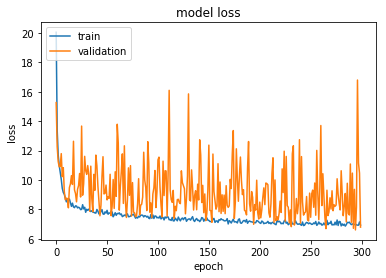

In [13]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, np_printoptions, \
                         find_efficiency_errors)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


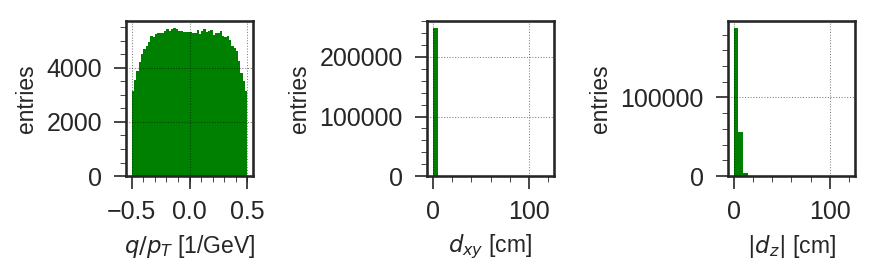

In [15]:
# Plot q/pT, d0, dz

fig, axs = plt.subplots(1, 3, figsize=(6,6/3), tight_layout=True)

axs[0].hist(y_test/reg_pt_scale, bins=50, range=(-0.5,0.5), color='g')
axs[0].set_xlabel(r'$q/p_{T}$ [1/GeV]', fontsize=11)
axs[0].set_ylabel(r'entries', fontsize=11)

axs[1].hist(dxy_test/reg_dxy_scale, bins=24, range=(0,120), color='g')
axs[1].set_xlabel(r'$d_{xy}$ [cm]', fontsize=11)
axs[1].set_ylabel(r'entries', fontsize=11)

axs[2].hist(np.abs(dz_test), bins=24, range=(0,120), color='g')
axs[2].set_xlabel(r'$|d_{z}|$ [cm]', fontsize=11)
axs[2].set_ylabel(r'entries', fontsize=11)

plt.show()

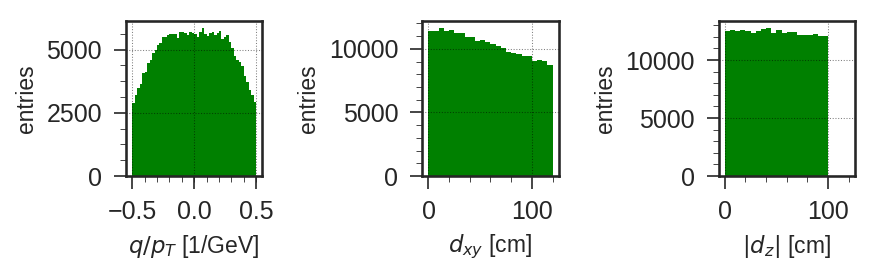

In [16]:
# Plot q/pT, d0, dz

fig, axs = plt.subplots(1, 3, figsize=(6,6/3), tight_layout=True)

axs[0].hist(y_test_displ/reg_pt_scale, bins=50, range=(-0.5,0.5), color='g')
axs[0].set_xlabel(r'$q/p_{T}$ [1/GeV]', fontsize=11)
axs[0].set_ylabel(r'entries', fontsize=11)

axs[1].hist(dxy_test_displ/reg_dxy_scale, bins=24, range=(0,120), color='g')
axs[1].set_xlabel(r'$d_{xy}$ [cm]', fontsize=11)
axs[1].set_ylabel(r'entries', fontsize=11)

axs[2].hist(np.abs(dz_test_displ), bins=24, range=(0,120), color='g')
axs[2].set_xlabel(r'$|d_{z}|$ [cm]', fontsize=11)
axs[2].set_ylabel(r'entries', fontsize=11)

plt.show()

In [17]:
# Predictions

y_test_true = y_test.copy()
y_test_true /= reg_pt_scale

y_test_meas = model.predict(x_test, batch_size=4096)
y_test_meas /= reg_pt_scale
y_test_meas = y_test_meas.reshape(-1)

y_test_meas_check = model_displ.predict(x_test, batch_size=4096)
y_test_meas_check /= reg_pt_scale
y_test_meas_check = y_test_meas_check.reshape(-1)

y_test_true_displ = y_test_displ.copy()
y_test_true_displ /= reg_pt_scale

y_test_meas_displ = model_displ.predict(x_test_displ, batch_size=4096)
y_test_meas_displ /= reg_pt_scale
y_test_meas_displ = y_test_meas_displ.reshape(-1)

y_test_meas_check_displ = model.predict(x_test_displ, batch_size=4096)
y_test_meas_check_displ /= reg_pt_scale
y_test_meas_check_displ = y_test_meas_check_displ.reshape(-1)

In [18]:
print y_test_true.shape, y_test_meas.shape, y_test_meas_check.shape
print y_test_true_displ.shape, y_test_meas_displ.shape, y_test_meas_check_displ.shape

(248000,) (248000,) (248000,)
(248000,) (248000,) (248000,)


[INFO    ] # of entries: 248000, mean: 0.000259162537986, std: 0.0410723052919
[INFO    ] gaus fit (a, mu, sig): [ 1.89271240e+04 -1.01620414e-03  2.90920305e-02]


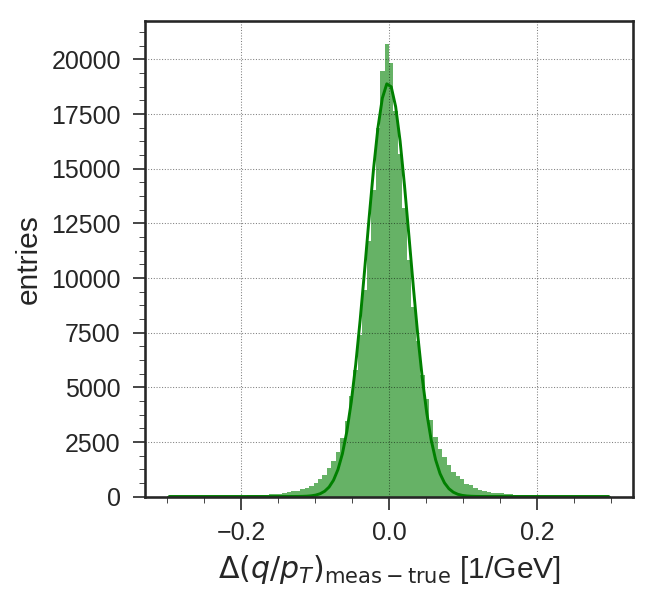

In [19]:
# Plot Delta(q/pT) - (a)

plt.figure()
yy = y_test_meas - y_test_true
hist, edges, _ = plt.hist(yy, bins=100, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

[INFO    ] # of entries: 248000, mean: 0.00890792626888, std: 0.0710089057684
[INFO    ] gaus fit (a, mu, sig): [1.11018339e+04 1.00121638e-02 4.80296354e-02]


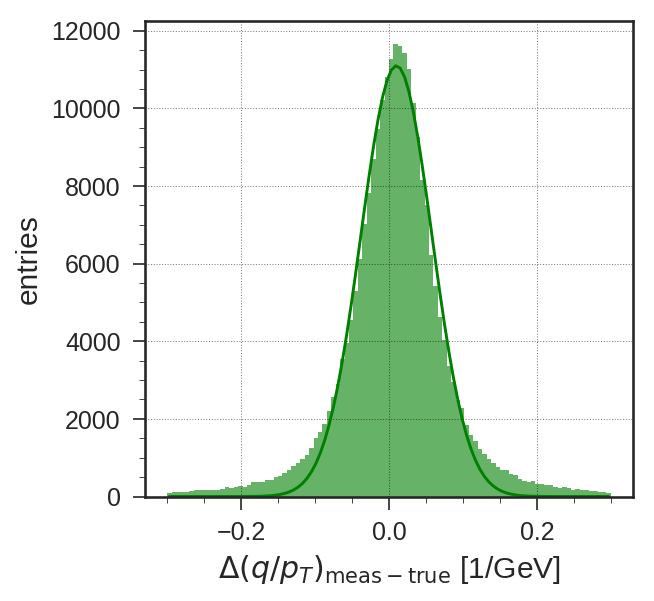

In [20]:
# Plot Delta(q/pT) - (b)

plt.figure()
yy = y_test_meas_displ - y_test_true_displ
hist, edges, _ = plt.hist(yy, bins=100, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

[INFO    ] # of entries: 248000, mean: 0.0117071960121, std: 0.0686646178365
[INFO    ] gaus fit (a, mu, sig): [1.16456645e+04 1.20641460e-02 4.59177207e-02]


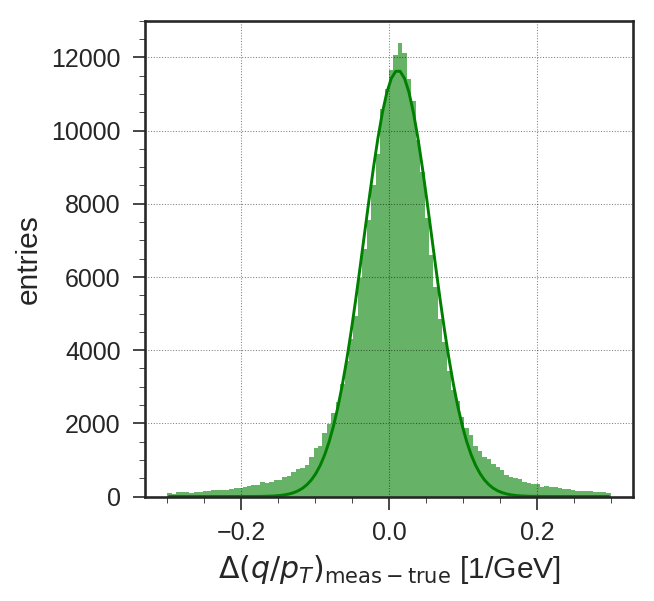

In [21]:
# Plot Delta(q/pT) - (c)

plt.figure()
yy = y_test_meas_check - y_test_true
hist, edges, _ = plt.hist(yy, bins=100, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

[INFO    ] # of entries: 248000, mean: -0.000548108131625, std: 0.126125097275
[INFO    ] gaus fit (a, mu, sig): [ 4.09667320e+03 -3.73503145e-04  1.17664000e-01]


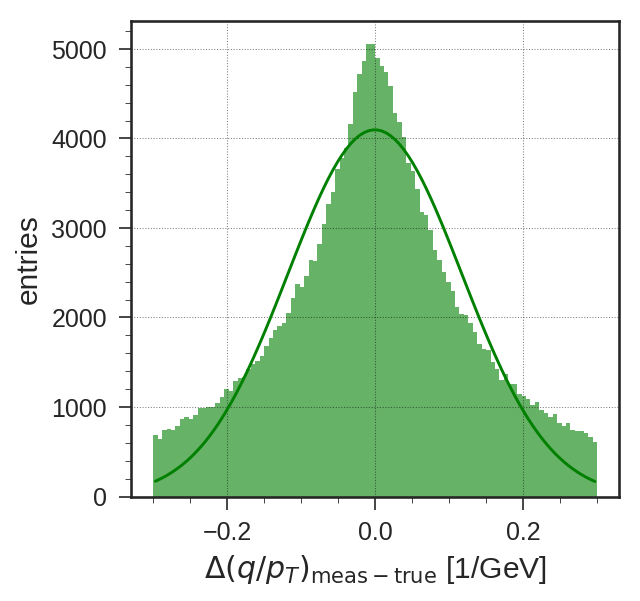

In [22]:
# Plot Delta(q/pT) - (d)

plt.figure()
yy = y_test_meas_check_displ - y_test_true_displ
hist, edges, _ = plt.hist(yy, bins=100, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

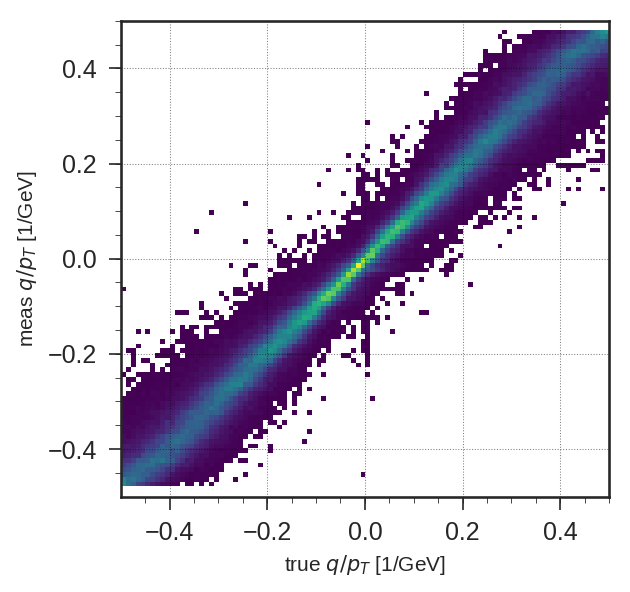

In [23]:
# Scatter plot - (a)

plt.figure()
plt.hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()

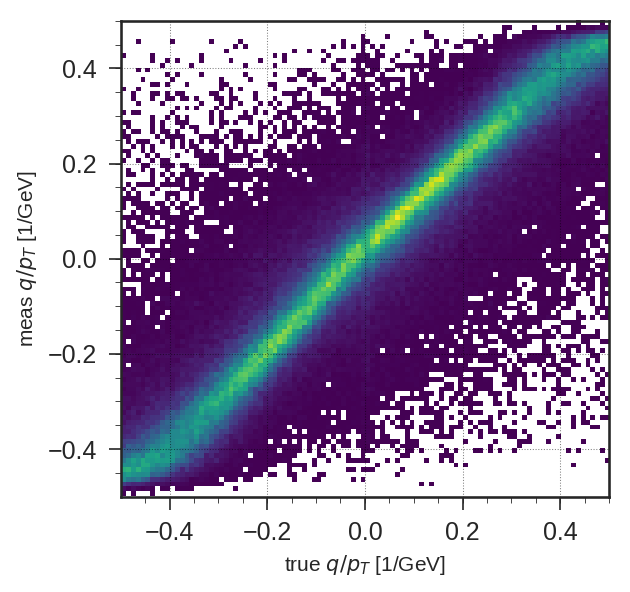

In [24]:
# Scatter plot - (b)

plt.figure()
plt.hist2d(y_test_true_displ, y_test_meas_displ, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()

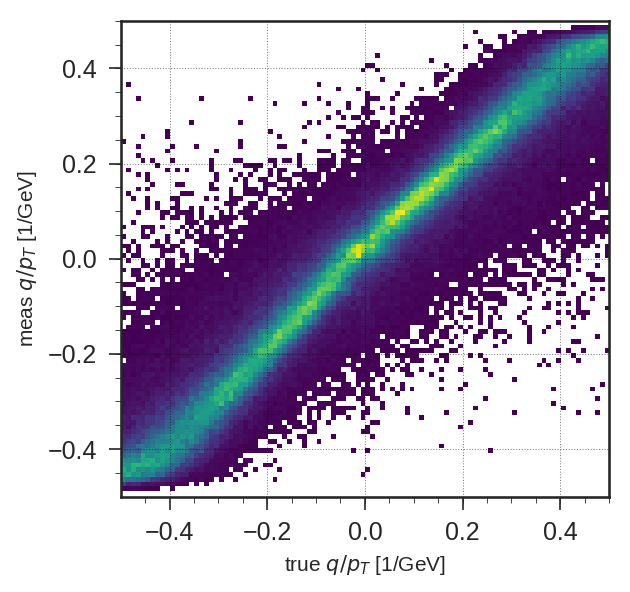

In [25]:
# Scatter plot - (c)

plt.figure()
plt.hist2d(y_test_true, y_test_meas_check, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()

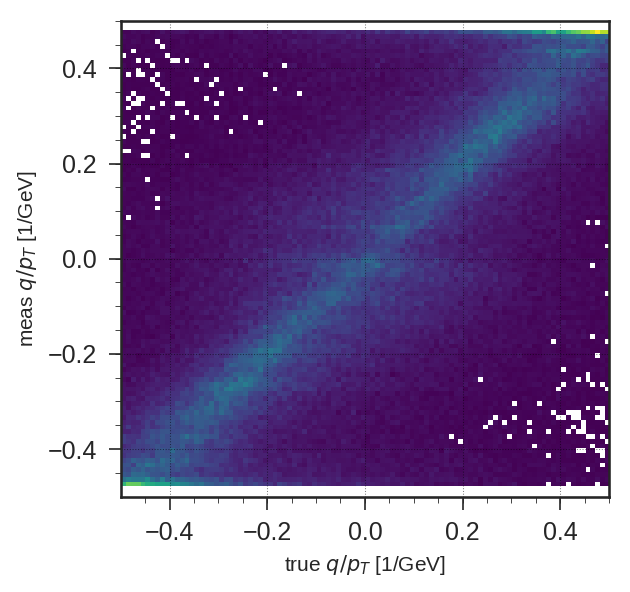

In [26]:
# Scatter plot - (d)

plt.figure()
plt.hist2d(y_test_true_displ, y_test_meas_check_displ, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()

### Training (Part II)

Try different cases:
- (a) Train with d0 only
- (b) Train with pT & d0, check pT & d0 resolution

In [27]:
model_d0 = create_model_sequential_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=50, nodes2=40, nodes3=30, nodes4=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_11 (Batc (None, 36)                144       
_________________________________________________________________
dense_11 (Dense)             (None, 50)                1800      
_________________________________________________________________
batch_normalization_12 (Batc (None, 50)                200       
_________________________________________________________________
activation_9 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 40)                2000      
_________________________________________________________________
batch_normalization_13 (Batc (None, 40)                160       
_________________________________________________________________
activation_10 (Activation)   (None, 40)                0         
__________

In [28]:
logger.info('Begin training ...')
history = model_d0.fit(x_train_displ, dxy_train_displ,
                    epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, verbose=0)
logger.info('Done training.')
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
    len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

[INFO    ] Begin training ...
[INFO    ] Done training.
[INFO    ] Epoch 300/300 - loss: 0.415334623146 - val_loss: 0.422701439115


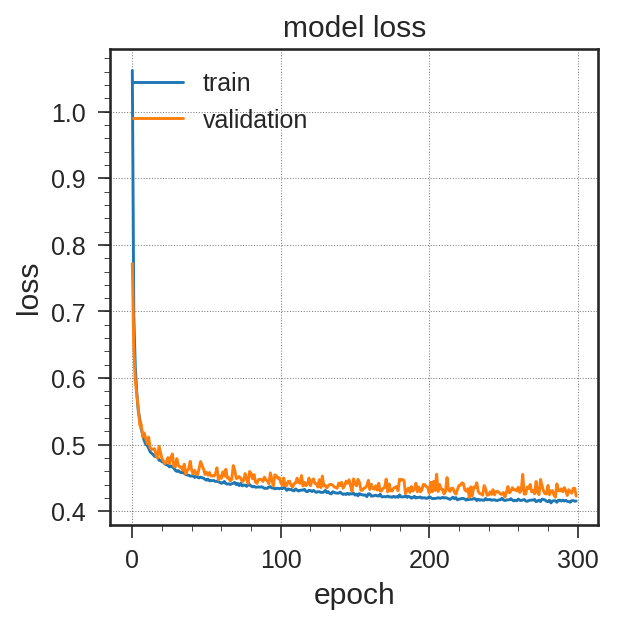

In [29]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [30]:
model_y_d0 = create_model_sequential_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=50, nodes2=40, nodes3=30, nodes4=20, outnodes=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_16 (Batc (None, 36)                144       
_________________________________________________________________
dense_16 (Dense)             (None, 50)                1800      
_________________________________________________________________
batch_normalization_17 (Batc (None, 50)                200       
_________________________________________________________________
activation_13 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 40)                2000      
_________________________________________________________________
batch_normalization_18 (Batc (None, 40)                160       
_________________________________________________________________
activation_14 (Activation)   (None, 40)                0         
__________

In [31]:
logger.info('Begin training ...')
history = model_y_d0.fit(x_train_displ, np.column_stack((y_train_displ, dxy_train_displ)),
                    epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, verbose=0)
logger.info('Done training.')
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(
    len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

[INFO    ] Begin training ...
[INFO    ] Done training.
[INFO    ] Epoch 300/300 - loss: 3.4764686484 - val_loss: 4.67582902107


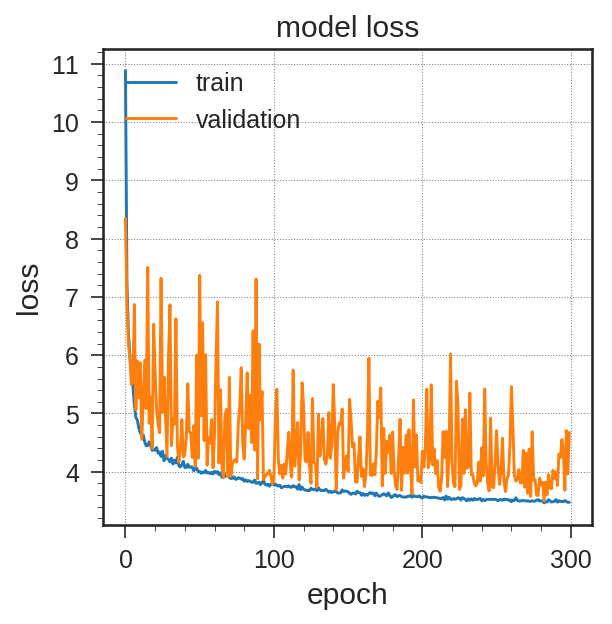

In [32]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [33]:
# Predictions

y_test_true = y_test_displ.copy()
y_test_true /= reg_pt_scale

y_test_meas = model_y_d0.predict(x_test_displ, batch_size=4096)[:,0]
y_test_meas /= reg_pt_scale
y_test_meas = y_test_meas.reshape(-1)

dxy_test_true = dxy_test_displ.copy()
dxy_test_true /= reg_dxy_scale

dxy_test_meas = model_y_d0.predict(x_test_displ, batch_size=4096)[:,1]
dxy_test_meas /= reg_dxy_scale
dxy_test_meas = dxy_test_meas.reshape(-1)

dxy_test_meas_check = model_d0.predict(x_test_displ, batch_size=4096)
dxy_test_meas_check /= reg_dxy_scale
dxy_test_meas_check = dxy_test_meas_check.reshape(-1)

In [34]:
print y_test_true.shape, y_test_meas.shape, dxy_test_true.shape, dxy_test_meas.shape, dxy_test_meas_check.shape

(248000,) (248000,) (248000,) (248000,) (248000,)


[INFO    ] # of entries: 248000, mean: -0.64736020565, std: 0.172952696681
[INFO    ] gaus fit (a, mu, sig): [1.37198607e+04 1.63080251e-01 1.67235128e+01]


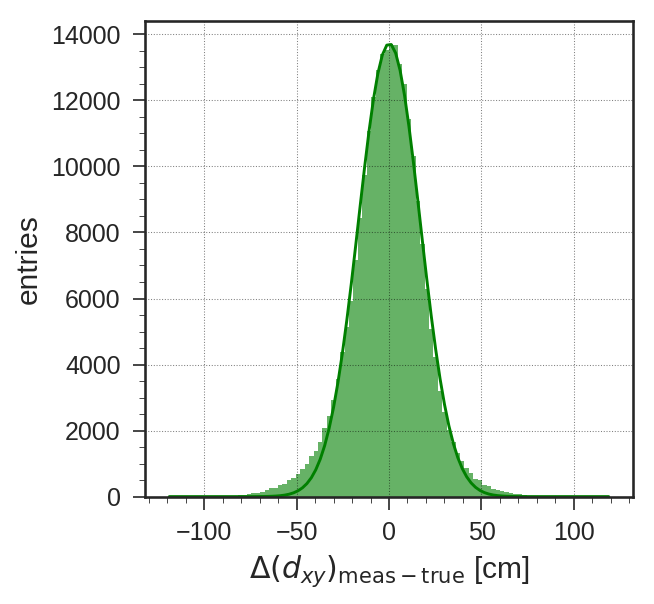

In [35]:
# Plot Delta(dxy) - (a)

plt.figure()
yy = dxy_test_meas_check - dxy_test_true
hist, edges, _ = plt.hist(yy, bins=100, range=(-120,120), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(d_{xy})_{\mathrm{meas-true}}$ [cm]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

[INFO    ] # of entries: 248000, mean: -0.780730545521, std: 0.174038946629
[INFO    ] gaus fit (a, mu, sig): [ 1.25461400e+04 -1.76161381e-01  1.82738400e+01]


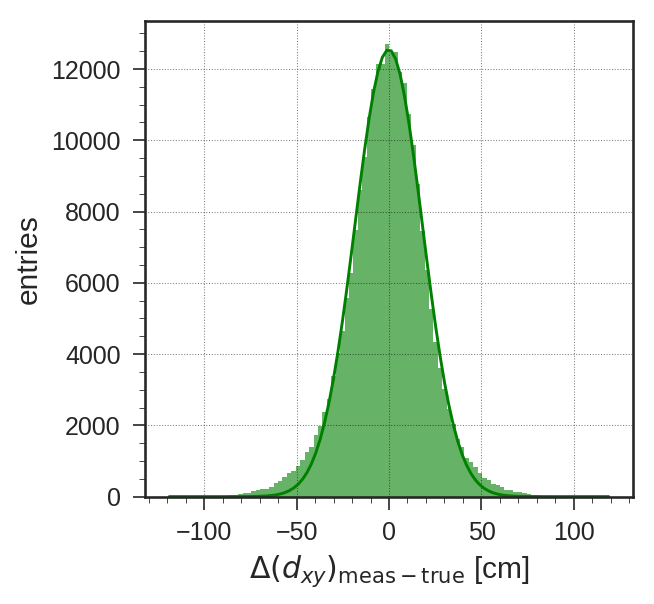

In [36]:
# Plot Delta(dxy) - (b)

plt.figure()
yy = dxy_test_meas - dxy_test_true
hist, edges, _ = plt.hist(yy, bins=100, range=(-120,120), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(d_{xy})_{\mathrm{meas-true}}$ [cm]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

[INFO    ] # of entries: 248000, mean: -0.0395155027509, std: 0.0793568938971
[INFO    ] gaus fit (a, mu, sig): [ 9.05820497e+03 -2.70003651e-02  5.91050434e-02]


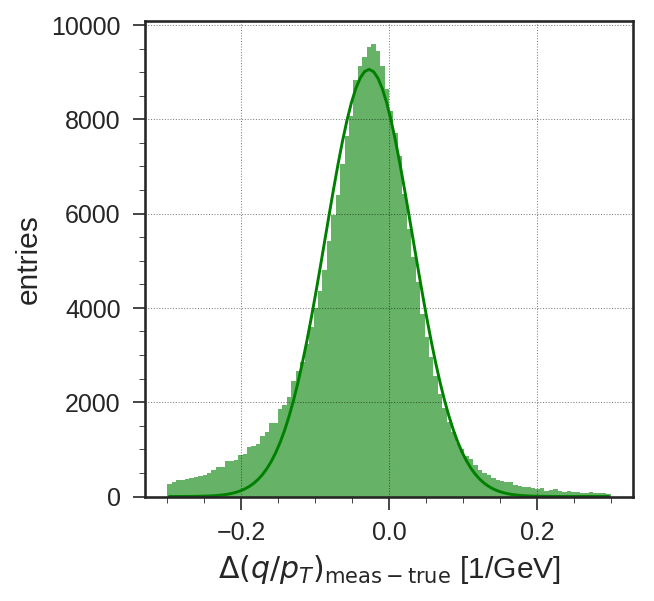

In [37]:
# Plot Delta(q/pT) - (b)

plt.figure()
yy = y_test_meas - y_test_true
hist, edges, _ = plt.hist(yy, bins=100, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

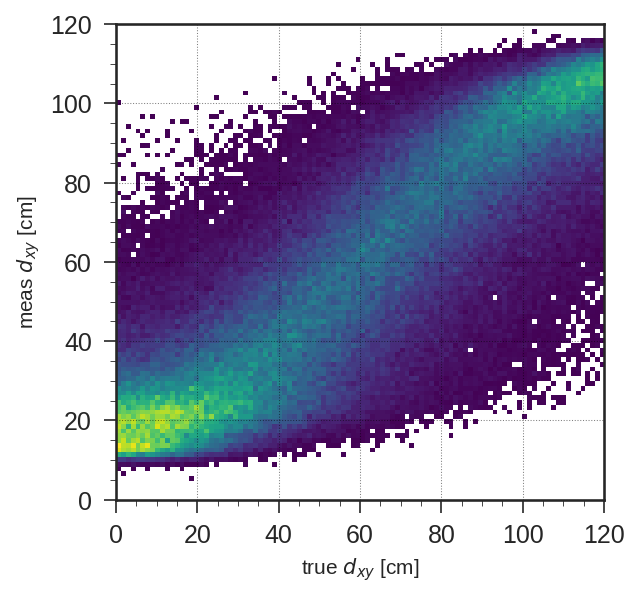

In [38]:
# Scatter plot - (a)

plt.figure()
plt.hist2d(dxy_test_true, dxy_test_meas_check, bins=(100,100), range=((0,120),(0,120)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $d_{xy}$ [cm]', fontsize=10)
plt.ylabel(r'meas $d_{xy}$ [cm]', fontsize=10)
plt.show()

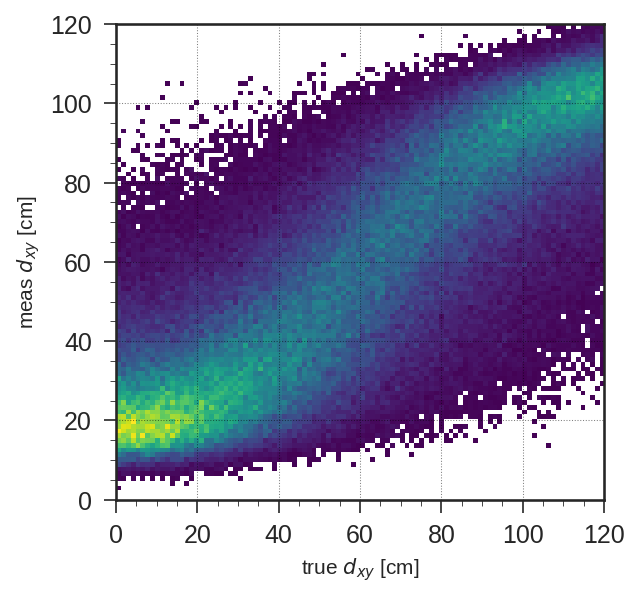

In [39]:
# Scatter plot - (b)

plt.figure()
plt.hist2d(dxy_test_true, dxy_test_meas, bins=(100,100), range=((0,120),(0,120)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $d_{xy}$ [cm]', fontsize=10)
plt.ylabel(r'meas $d_{xy}$ [cm]', fontsize=10)
plt.show()

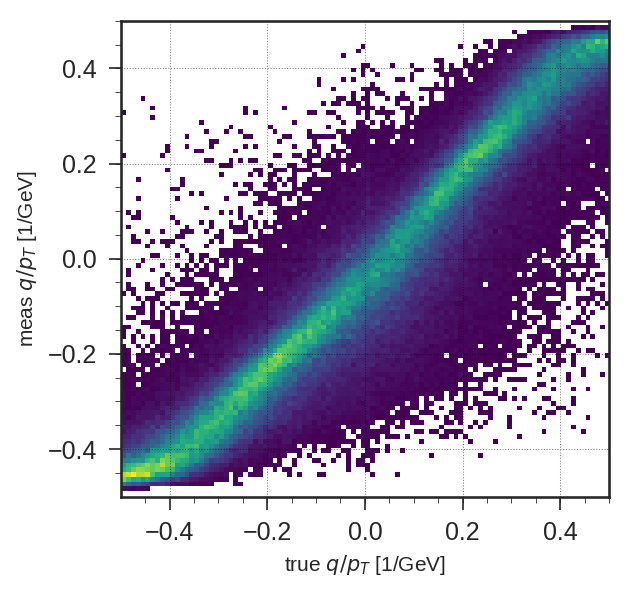

In [40]:
# Scatter plot - (b)

plt.figure()
plt.hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()